In [1]:
from functions import *


import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
from skimage.feature import blob_log
from apsg import *

microm2m = 1.0E-6
m2microm = 1.0E6

In [2]:
import pandas as pd

# read data from csv file

data = pd.read_csv('dataframe2.csv', delimiter=',')
data.head()

,Radius (μm),Hc (mT),TRM (A/m),D (°),I (°),Xc (μm),Yc (μm),Zc (μm),mx (Am$^2$),my (Am$^2$),mz (Am$^2$)
0,0.483931,91.450632,50078.954779,45.0,45.0,512,338,7,1.188675e-14,1.188675e-14,1.681041e-14
1,0.225637,71.362836,45342.662565,45.0,45.0,830,666,5,1.090924e-15,1.090924e-15,1.542799e-15
2,0.130361,82.158073,53272.407824,45.0,45.0,614,894,3,2.471756e-16,2.471756e-16,3.495591e-16
3,0.384239,63.661202,50304.597884,45.0,45.0,303,958,8,5.976841e-15,5.976841e-15,8.452530e-15
4,0.245077,69.122011,49111.865486,45.0,45.0,959,225,6,1.514094e-15,1.514094e-15,2.141252e-15


In [3]:
flight = 5.0  # sample-sensor distance
area = (0, 1000*microm2m, 0, 1000*microm2m)
shape = (1000,1000)
z = -flight*microm2m

f = np.matrix(regular(area, shape, z))
X = np.array(f[0])
Y = np.array(f[1])
Z = np.array(f[2])

cm = 10**(-7) # H/m  == T·m/A


# read generated sourcers
index = (data["Hc (mT)"]<=1000)
g     =  data[index]


D = np.array(g['D (°)'])
I = np.array(g['I (°)'])
Q = np.array(g['TRM (A/m)'])
R = np.array(g['Radius (μm)'])*microm2m

Xc = np.array(g['Xc (μm)'])*microm2m
Yc = np.array(g['Yc (μm)'])*microm2m
Zc = np.array(g['Zc (μm)'])*microm2m



m = cartesian_components(D, I, Q, R)
M = sensibility_matrix(X, Y, Z, Xc, Yc, Zc)


In [4]:
# data vector direct model
d = np.matmul(M, m)

#apply noise
d = noise(d, error=150.0E-9, method='fixed') # noise of 150 nT with 'fixed' method

# Reshape data vector for the map plot
d_= np.reshape(d, shape)

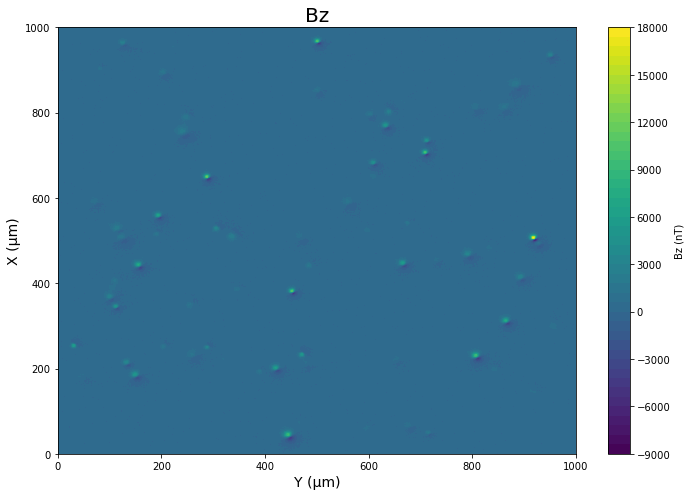

In [5]:
xs = np.linspace(area[0], area[1], shape[0])
ys = np.linspace(area[2], area[3], shape[1])

x_plot = np.reshape(Y,(np.size(xs),np.size(ys)))*m2microm
y_plot = np.reshape(X,(np.size(xs),np.size(ys)))*m2microm

# plot do mapa de dados do modelo direto

plt.figure(figsize=(10, 7))
plt.contourf(x_plot, y_plot, d_*10**9, levels=50, cmap='viridis')
plt.colorbar(label='Bz (nT)')

plt.title('Bz', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)

plt.tight_layout()

plt.show()

In [6]:
X_ = np.reshape(X, shape)
Y_ = np.reshape(Y, shape)
Z_ = np.reshape(Z, shape)


# calculating derivatives using Fast Fourier Transform (FFT)

wx, wy, wz = wave_numbers(d_, X_, Y_)

ddx = x_derivative_fft(d_, wx, order=1)
ddy = y_derivative_fft(d_, wy, order=1)
ddz = z_derivative_fft(d_, wz, order=1)

# calculating derivatives (x and y) using Finite Differences (FD)
d_X, d_Y = (derivative_fd(d_, X_,Y_, order=1))


In [35]:
# upward_continuation filtering --> to remove high frequency noise
height = 2.0      # delta_z upward continuation
delta_z = -height*microm2m
upward = upward_continuation(d_, delta_z, wz)


# upward_continuation --> used later to calculate the Z derivative by FD
delta_z1 = -(height-0.1)*microm2m
upward1 = upward_continuation(d_, delta_z1, wz)

delta_z2 = -(height+0.1)*microm2m
upward2 = upward_continuation(d_, delta_z2, wz)

Text(0, 0.5, 'X (µm)')

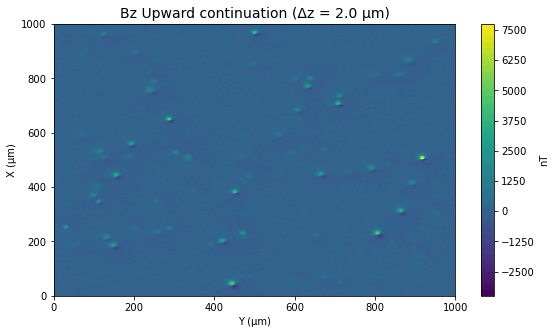

In [36]:
# upward continuation plot

plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, (upward)*10**9, levels=50, cmap='viridis')
plt.colorbar(label='nT')

plt.title('Bz Upward continuation (Δz = %s µm)'%height, fontsize=14)
plt.xlabel('Y (µm)', fontsize=10)
plt.ylabel('X (µm)', fontsize=10)


In [37]:
# Novas derivadas (em x e y) usando a continuação p/ cima por FD
d_X, d_Y = (derivative_fd(upward, X_,Y_))
d_Z = z_derivative_fd(upward1, upward2, delta_z1, delta_z2)

In [38]:
Total_Grad_FD = Total_Grad(d_Y , d_X, d_Z)

Text(0, 0.5, 'X (µm)')

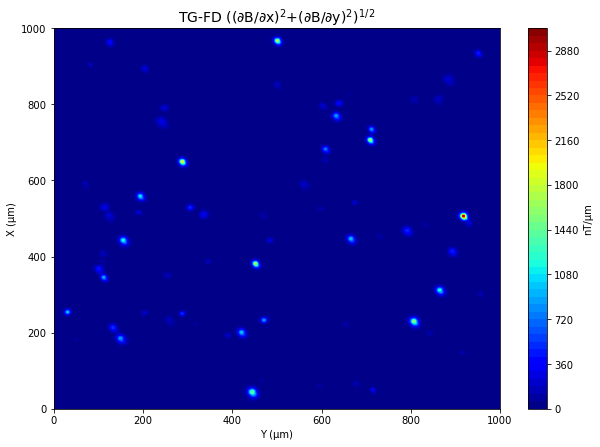

In [39]:
fig, ((ax1)) = plt.subplots(1,1, figsize=(10,7))

# plot FD horizontal gradient 
ax1_plot  = ax1.contourf(x_plot, y_plot, Total_Grad_FD*10**3, levels=50, cmap='jet')
plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
ax1.set_title('TG-FD'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$)$^1$$^/$$^2$', fontsize=14)
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

Text(0, 0.5, 'Count')

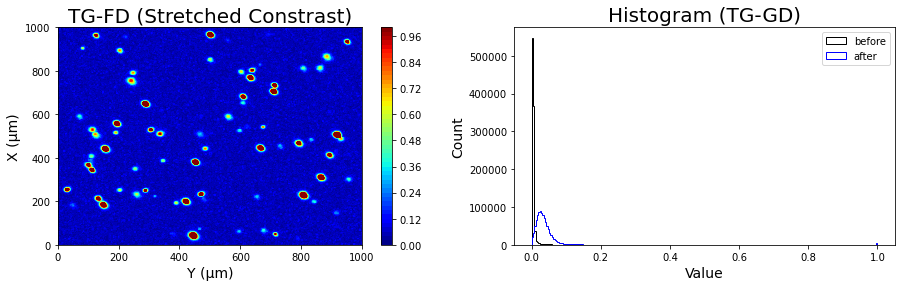

In [40]:
import skimage
import scipy.signal as signal

image =  Total_Grad_FD/Total_Grad_FD.max()

perc_min, perc_max = np.percentile(image, (0.5,99.5))
stretched_image = skimage.exposure.rescale_intensity(image, in_range=(perc_min, perc_max))



fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(15,4))

ax1_plot = ax1.contourf(x_plot, y_plot, stretched_image, levels=50, cmap='jet')
ax1.set_title('TG-FD (Stretched Constrast)', fontsize=20)
ax1.set_xlabel('Y (µm)', fontsize=14)
ax1.set_ylabel('X (µm)', fontsize=14)

plt.colorbar(ax1_plot, ax=ax1)

ax2.hist(image.ravel(), bins=256, histtype='step', color='k', label='before');
ax2.hist(stretched_image.ravel(), bins=256, histtype='step', color='b', label='after');
ax2.legend()
ax2.set_title('Histogram (TG-GD)', fontsize=20)
ax2.set_xlabel('Value', fontsize=14)
ax2.set_ylabel('Count', fontsize=14)


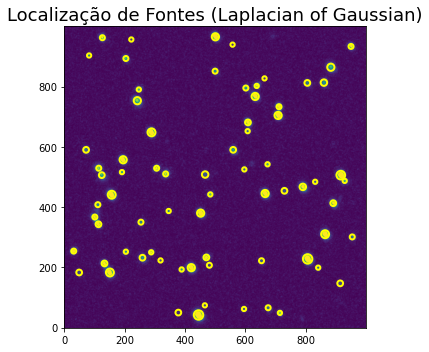

(72, 4)


()

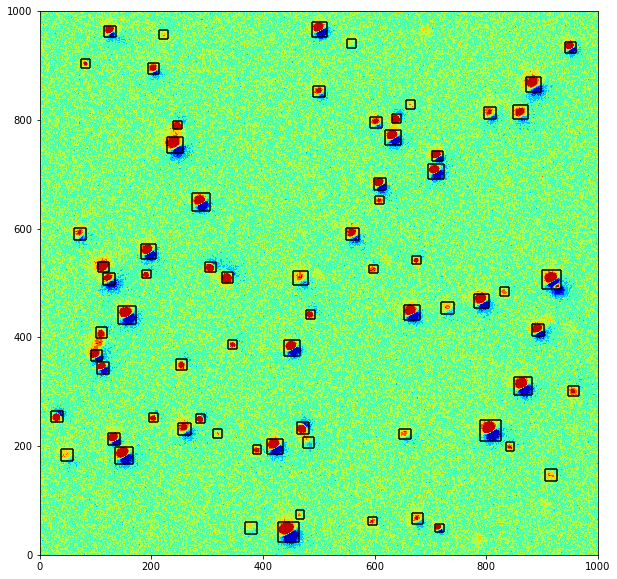

In [41]:
circles_FD, euler_windows_FD = sources_finder(stretched_image, threshold=0.05, min_sigma=5, max_sigma=30, num_sigma=30, overlap=1.0, radius_increment=0.2)
print(np.shape(euler_windows_FD))

Xc_FD, Yc_FD, Zc_FD, filtered_euler_windows_FD = solve_euler_windows(euler_windows_FD, X_, Y_, Z_, upward, d_X, d_Y, d_Z, delta_z, structural_index = 3.0)

import skimage
perc_min, perc_max = np.percentile(d_, (0.5,99.5))
view = skimage.exposure.rescale_intensity(d_, in_range=(perc_min, perc_max))
euler_windows_view(X_, Y_, Z_, view, filtered_euler_windows_FD, show_windows=False, color='k')


Euler Solutions:
    Xc (µm)   Yc (µm)  Zc (µm)
0  648.0211  288.9946   1.0967
1  965.9971  501.9646   1.0365
2  380.0096  453.0199   1.0436
3  228.0012  808.0244   3.0378
4   42.0543  446.0028   4.0352

Original Positions:
   Xc (µm)  Yc (µm)  Zc (µm)
0    512.0    338.0      7.0
1    830.0    666.0      5.0
2    614.0    894.0      3.0
3    303.0    958.0      8.0
4    959.0    225.0      6.0



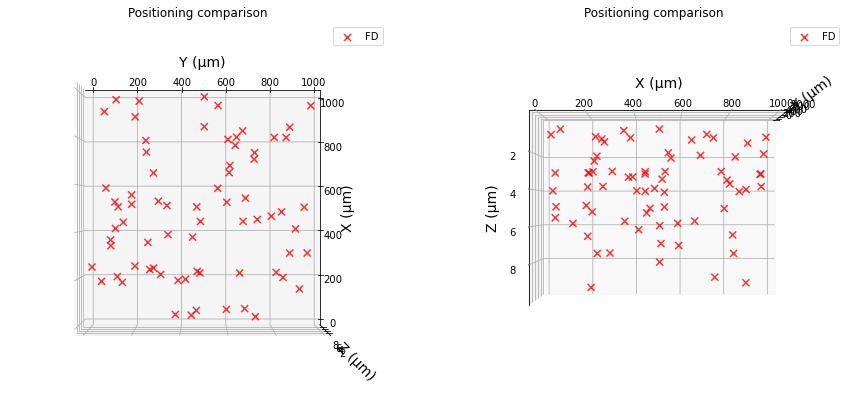

In [42]:
import pandas as pd
print('Euler Solutions:')
df1 = pd.DataFrame(data={'Xc (µm)': (np.round(Xc_FD*m2microm, decimals=4)),
                        'Yc (µm)': (np.round(Yc_FD*m2microm, decimals=4)),
                        'Zc (µm)': (np.round(Zc_FD*m2microm, decimals=4))
                       })

print(df1.head(5))
print()

print('Original Positions:')
df2 = pd.DataFrame(data={
                        'Xc (µm)': (np.round(Xc*m2microm, decimals=4)),
                        'Yc (µm)': (np.round(Yc*m2microm, decimals=4)),
                        'Zc (µm)': (np.round(Zc*m2microm, decimals=4))
                       })

print(df2.head(5))
print()

from mpl_toolkits.mplot3d import axes3d


fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.scatter(Yc_FD*m2microm, Xc_FD*m2microm, Zc_FD*m2microm,
            alpha=0.8, color='r', marker='x', s=50, label='FD')

ax1.set_title('Positioning comparison')
ax1.legend(loc='best')
ax1.invert_zaxis()

ax1.set_xlabel('Y (µm)', fontsize=14)
ax1.set_ylabel('X (µm)', fontsize=14)
ax1.set_zlabel('Z (µm)', fontsize=14)

ax1.azim = -90
ax1.dist = 10
ax1.elev = 90



ax2.scatter(Yc_FD*m2microm, Xc_FD*m2microm, Zc_FD*m2microm,
            alpha=0.8, color='r', marker='x', s=50, label='FD')

ax2.set_title('Positioning comparison')
ax2.legend(loc='best')
ax2.invert_zaxis()

ax2.set_xlabel('Y (µm)', fontsize=14)
ax2.set_ylabel('X (µm)', fontsize=14)
ax2.set_zlabel('Z (µm)', fontsize=14)

ax2.azim = 0
ax2.dist = 10
ax2.elev = 0

plt.show()

# Magnetic inversion using lest square method


,Dec (°),$\sigma D$ (°),Inc (°),$\sigma I$ (°),m ($A \cdot m^2$),$\sigma m$ ($A \cdot m^2$),Xc (µm),Yc (µm),Zc (µm)
0,149.8747,0.1324,15.3240,0.0934,2.307716e-14,5.051331e-17,648.021069,288.994568,1.096696
1,150.0966,0.1484,15.2176,0.1047,2.016597e-14,4.953307e-17,965.997078,501.964631,1.036475
2,149.8230,0.1475,15.0811,0.1040,2.033057e-14,4.966438e-17,380.009619,453.019905,1.043567
3,149.9972,0.1203,15.1072,0.0849,4.409007e-14,8.785576e-17,228.001213,808.024405,3.037772
4,149.9597,0.1137,15.3336,0.0802,5.901460e-14,1.109484e-16,42.054342,446.002769,4.035161
...,...,...,...,...,...,...,...,...,...
61,43.8252,2.2857,41.0305,1.4585,4.534193e-15,1.208597e-16,63.352540,597.821062,4.931559
62,53.7042,3.7085,23.3119,2.5899,7.202995e-16,4.110516e-17,75.803025,468.632148,0.563190
63,42.4722,2.0545,34.8671,1.3730,5.510173e-15,1.482768e-16,149.009604,917.743522,5.825277
64,33.8412,6.4980,53.0911,3.5330,7.124724e-16,4.002444e-17,224.269401,319.669256,0.922593


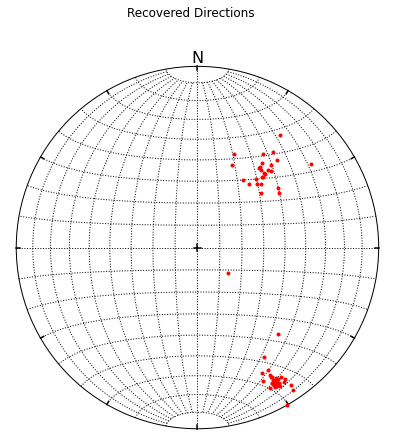

In [43]:
error = 0.05
d = np.squeeze(d)

# Magnetic inversion using FD euler positions and magnetic data before the upward continuation
hx_FD_least, hy_FD_least, hz_FD_least, M_FD_least, direct_model_FD_least = least_square_solver(X, Y, Z, Xc_FD, Yc_FD, Zc_FD, d)
D_FD_least, I_FD_least = directions(hx_FD_least, hy_FD_least, hz_FD_least, plot=True, show_mean=False, show_alpha95=False)


momentum_FD_least = (np.sqrt(hx_FD_least**2 + hy_FD_least**2 + hz_FD_least**2))


#Inversion uncertainties
sigma_noise = (np.absolute(np.max(d))+np.absolute(np.min(d))) * error
sigma_noise = 150*1.0e-9 # noise of 150 nT
sigma_D_FD_least, sigma_I_FD_least, sigma_m_FD_least = uncertainties(sigma_noise, M_FD_least, hx_FD_least, hy_FD_least, hz_FD_least)

import pandas as pd
df = pd.DataFrame(data={'Dec (°)': (np.round(D_FD_least, decimals=4)),
                        '$\sigma D$ (°)':    (np.round(sigma_D_FD_least, decimals=4)),
                        'Inc (°)': (np.round(I_FD_least, decimals=4)),
                        '$\sigma I$ (°)':    (np.round(sigma_I_FD_least, decimals=4)),
                        'm  ($A \cdot m^2$)':  (momentum_FD_least),
                        '$\sigma m$ ($A \cdot m^2$)':  (sigma_m_FD_least),
                        'Xc (µm)': Xc_FD*m2microm,
                        'Yc (µm)': Yc_FD*m2microm,
                        'Zc (µm)': Zc_FD*m2microm
                        
                       })

df.head(-5)



# Direct Model and Errors

### Whole Area

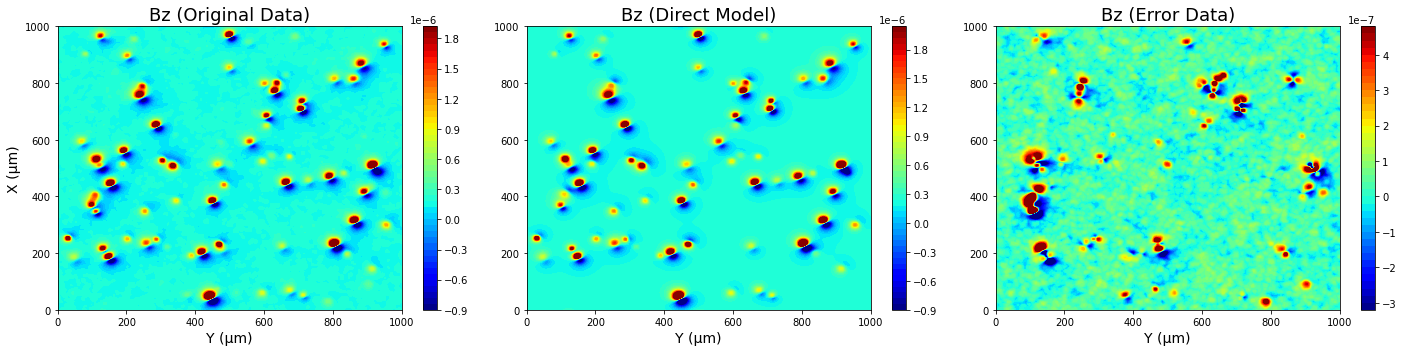

In [34]:
direct_model_FD_least = np.reshape(direct_model_FD_least, shape)

upward_direct_model_FD_least = upward_continuation(direct_model_FD_least, delta_z, wz)

fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(20,5))

perc_min, perc_max = np.percentile(upward, (0.5,99.5))
original_data_view = skimage.exposure.rescale_intensity(upward, in_range=(perc_min, perc_max))
ax4_plot = ax1.contourf(x_plot, y_plot, upward, levels=50, cmap='jet')
ax1_plot = ax1.contourf(x_plot, y_plot, original_data_view, levels=50, cmap='jet')

plt.colorbar(ax4_plot, ax=ax1)
ax1.set_title('Bz (Original Data)', fontsize=18)
ax1.set_xlabel('Y (µm)', fontsize=14)
ax1.set_ylabel('X (µm)', fontsize=14)


perc_min, perc_max = np.percentile(upward_direct_model_FD_least, (0.5,99.5))
direct_model_view = skimage.exposure.rescale_intensity(upward_direct_model_FD_least, in_range=(perc_min, perc_max))
ax5_plot = ax2.contourf(x_plot, y_plot, upward_direct_model_FD_least, levels=50, cmap='jet')
ax2_plot = ax2.contourf(x_plot, y_plot, direct_model_view, levels=50, cmap='jet')
plt.colorbar(ax5_plot, ax=ax2)
ax2.set_title('Bz (Direct Model)', fontsize=18)
ax2.set_xlabel('Y (µm)', fontsize=14)

error = upward - upward_direct_model_FD_least
perc_min, perc_max = np.percentile(error, (0.5,99.5))
error_data_view = skimage.exposure.rescale_intensity(error, in_range=(perc_min, perc_max))
ax6_plot = ax3.contourf(x_plot, y_plot, error, levels=50, cmap='jet')
ax3_plot = ax3.contourf(x_plot, y_plot, error_data_view, levels=50, cmap='jet')
plt.colorbar(ax6_plot, ax=ax3)
ax3.set_title('Bz (Error Data)', fontsize=18)
ax3.set_xlabel('Y (µm)', fontsize=14)



plt.tight_layout()

#plt.savefig('teste.jpg', dpi=500)

### For each Window

In [17]:
Xc_save, Yc_save, Zc_save = [], [], []
hx_save, hy_save, hz_save = [], [], []
m_save, D_save, I_save = [], [], []
sigma_m_save, sigma_D_save, sigma_I_save = [], [], []
deter_coef_save = []

show=False


for i in range(np.shape(filtered_euler_windows_FD)[0]):
    
    if Zc_FD[i]>=0:
        x1, x2 = int(euler_windows_FD[i,0]), int(euler_windows_FD[i,1])
        y1, y2 = int(euler_windows_FD[i,2]), int(euler_windows_FD[i,3])

        data_normalized = upward[x1:x2, y1:y2]/(np.absolute(np.max(upward[x1:x2, y1:y2])
                                                         -np.min(upward[x1:x2, y1:y2])))

        model_normalized = (upward_direct_model_FD_least[x1:x2, y1:y2]/
                            (np.absolute(np.max(upward_direct_model_FD_least[x1:x2, y1:y2])
                            -np.min(upward_direct_model_FD_least[x1:x2, y1:y2]))) )

        error_normalized = data_normalized-model_normalized

        SQ_tot = np.sum( (data_normalized-np.mean(data_normalized))**2 )
        SQ_res = np.sum( (data_normalized-model_normalized)**2 )
        deter_coef = 1 - (SQ_res/SQ_tot)
        

        momentum = (np.sqrt(hx_FD_least[i]**2 + hy_FD_least[i]**2 + hz_FD_least[i]**2))
        Xc_save.append(Xc_FD[i]*m2microm)
        Yc_save.append(Yc_FD[i]*m2microm)
        Zc_save.append(Zc_FD[i]*m2microm)
        hx_save.append(hx_FD_least[i])
        hy_save.append(hy_FD_least[i])
        hz_save.append(hz_FD_least[i])
        m_save.append(momentum)
        sigma_m_save.append(sigma_m_FD_least[i])
        D_save.append(D_FD_least[i])
        sigma_D_save.append(sigma_D_FD_least[i])
        I_save.append(I_FD_least[i])
        sigma_I_save.append(sigma_I_FD_least[i])
        deter_coef_save.append(deter_coef)

        if show:
            print('R2: ', deter_coef)

            fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(20,5))

            ax1_plot = ax1.contourf(x_plot[x1:x2, y1:y2], y_plot[x1:x2, y1:y2], 
                                    upward[x1:x2, y1:y2], levels=50, cmap='viridis')
            plt.colorbar(ax1_plot, ax=ax1)
            ax1.set_title('Bz (Original Data)', fontsize=18)
            ax1.set_xlabel('Y (µm)', fontsize=14)
            ax1.set_ylabel('X (µm)', fontsize=14)


            ax2_plot = ax2.contourf(x_plot[x1:x2, y1:y2], y_plot[x1:x2, y1:y2], 
                                    upward_direct_model_FD_least[x1:x2, y1:y2], levels=50, cmap='viridis')
            plt.colorbar(ax2_plot, ax=ax2)
            ax2.set_title('Bz (Direct Model)', fontsize=18)
            ax2.set_xlabel('Y (µm)', fontsize=14)

            error = upward[x1:x2, y1:y2] - upward_direct_model_FD_least[x1:x2, y1:y2]
            ax3_plot = ax3.contourf(x_plot[x1:x2, y1:y2], y_plot[x1:x2, y1:y2], error, levels=50, cmap='viridis')
            plt.colorbar(ax3_plot, ax=ax3)
            ax3.set_title('Bz (Error Data)', fontsize=18)
            ax3.set_xlabel('Y (µm)', fontsize=14)

            plt.tight_layout()
            plt.show()

                    
df_final = pd.DataFrame(data={'Xc (µm)': np.array(np.round(Xc_save, decimals=4)),
                              'Yc (µm)': np.array(np.round(Yc_save, decimals=4)),
                              'Zc (µm)': np.array(np.round(Zc_save, decimals=4)),
                              'mx (Am2)': np.array(hx_save),
                              'my (Am2)': np.array(hy_save),
                              'mz (Am2)': np.array(hz_save),
                              'm (Am2)': np.array(m_save),
                              'sigma m (Am2)': np.array(sigma_m_save),
                              'D (°)': np.array(D_save),
                              'sigma D (°)': np.array(sigma_D_save),
                              'I (°)': np.array(I_save),
                              'sigma I (°)': np.array(sigma_I_save),
                              'R2': np.array(deter_coef_save)

                       })

In [18]:
df_final.head(-5)
display(df_final)

,Xc (µm),Yc (µm),Zc (µm),mx (Am2),my (Am2),mz (Am2),m (Am2),sigma m (Am2),D (°),sigma D (°),I (°),sigma I (°),R2
0,648.0720,289.0136,1.0846,-1.906911e-14,1.116364e-14,6.200535e-15,2.295005e-14,5.027130e-17,149.653987,0.132798,15.674698,0.093652,0.999868
1,42.0215,445.9252,4.0165,-4.917795e-14,2.811185e-14,1.560015e-14,5.875467e-14,1.104783e-16,150.246189,0.113765,15.397458,0.080246,0.999921
2,227.9762,808.0436,3.0157,-3.671080e-14,2.118602e-14,1.126170e-14,4.385609e-14,8.743319e-17,150.010508,0.120199,14.879532,0.084784,0.999741
3,966.0203,501.9482,1.0085,-1.667096e-14,9.580979e-15,5.335170e-15,1.995445e-14,4.904208e-17,150.113563,0.148819,15.507670,0.104966,0.999846
4,380.0178,453.0667,1.0259,-1.685536e-14,9.891594e-15,5.205044e-15,2.022472e-14,4.939269e-17,149.593390,0.147264,14.913502,0.103903,0.999831
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,79.2866,473.7898,3.5054,6.176808e-16,4.888768e-16,-1.418949e-16,8.004150e-16,9.929622e-17,38.360614,7.279626,-10.211170,5.144673,0.989641
67,826.4362,663.8296,3.4523,-2.873073e-16,3.214828e-16,1.195340e-15,1.270722e-15,7.383887e-17,131.786977,13.154253,70.165702,4.332686,0.398595
68,546.8253,623.3479,5.8346,1.380599e-15,1.037883e-15,2.316046e-15,2.889174e-15,1.341292e-16,36.934480,5.410925,53.285964,2.928416,0.722080
69,967.4689,692.7153,7.5918,1.290247e-15,1.374772e-15,2.769885e-15,3.350672e-15,1.780732e-16,46.816612,6.669748,55.757730,3.443010,0.919406


### Filtering data by: deternation coef. (R$^2$), $\sigma$D and $\sigma$I 

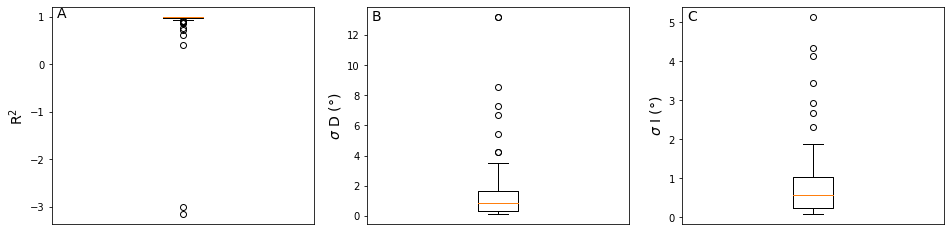

In [19]:
fig, axes = plt.subplots(1,3, figsize=(16,4))
axes[0].boxplot(df_final['R2'])
axes[0].set_xticks([])
axes[0].set_ylabel('R$^2$', fontsize=14)
ytext = df_final['R2'].max()
axes[0].text(0.52, ytext-0.02*ytext, 'A', fontsize=14)

axes[1].boxplot(df_final['sigma D (°)'])
axes[1].set_xticks([])
axes[1].set_ylabel('$\sigma$ D (°)', fontsize=14)
ytext = df_final['sigma D (°)'].max()
axes[1].text(0.52, ytext-0.02*ytext, 'B', fontsize=14)

axes[2].boxplot(df_final['sigma I (°)'])
axes[2].set_xticks([])
axes[2].set_ylabel('$\sigma$ I (°)', fontsize=14)
ytext = df_final['sigma I (°)'].max()
axes[2].text(0.52, ytext-0.02*ytext, 'C', fontsize=14)

plt.show()

#### Directions Recovered

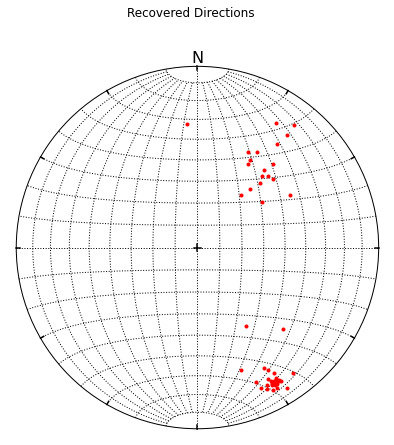

In [20]:
index = ((df_final['R2']>=0.95) & (df_final['sigma D (°)']<=5) & (df_final['sigma I (°)']<=3))
h=df_final[index]



D, I = directions(np.array(h['mx (Am2)']), np.array(h['my (Am2)']), np.array(h['mz (Am2)']), plot=True, show_mean=False, show_alpha95=False)

#### Momentum Recovered

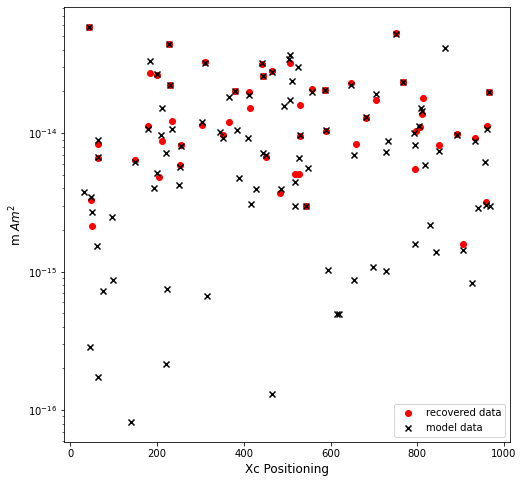

In [21]:
plt.figure(figsize=(8,8))
plt.scatter(h['Xc (µm)'], h['m (Am2)'], label='recovered data', color='r')

m_real = Q*4/3*np.pi*R**3
plt.scatter(Xc*m2microm, m_real, marker='x', label='model data', color='k')
plt.yscale('log')

plt.xlabel('Xc Positioning', fontsize=12)
plt.ylabel('m $Am^{2}$', fontsize=12)

plt.legend(loc='best')